/tmp/ipykernel_1332384/2036168318.py:93: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Labels', loc='upper left', fontsize=fz)
/tmp/ipykernel_1332384/2036168318.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=model, loc='upper left', fontsize=fz)
/tmp/ipykernel_1332384/2036168318.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=model, loc='upper left', fontsize=fz)
/tmp/ipykernel_1332384/2036168318.py:115: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is call

                         CCE  Reduced-F1     eTaPR    Aff-F1   VUS-ROC
PreQ1.0-NegP0.05-R  0.763675    0.750000  0.711628  0.939822  0.983453
PreQ0.9-NegP0.05-R  0.707078    0.705882  0.706417  0.956974  0.973797
PreQ0.9-NegP0.1-R   0.658383    0.800000  0.731979  0.939693  0.968658
PreQ0.9-NegP0.3-R   0.513205    0.352941  0.459277  0.788164  0.905152
PreQ0.8-NegP0.3-R   0.417379    0.480000  0.516391  0.811256  0.888148


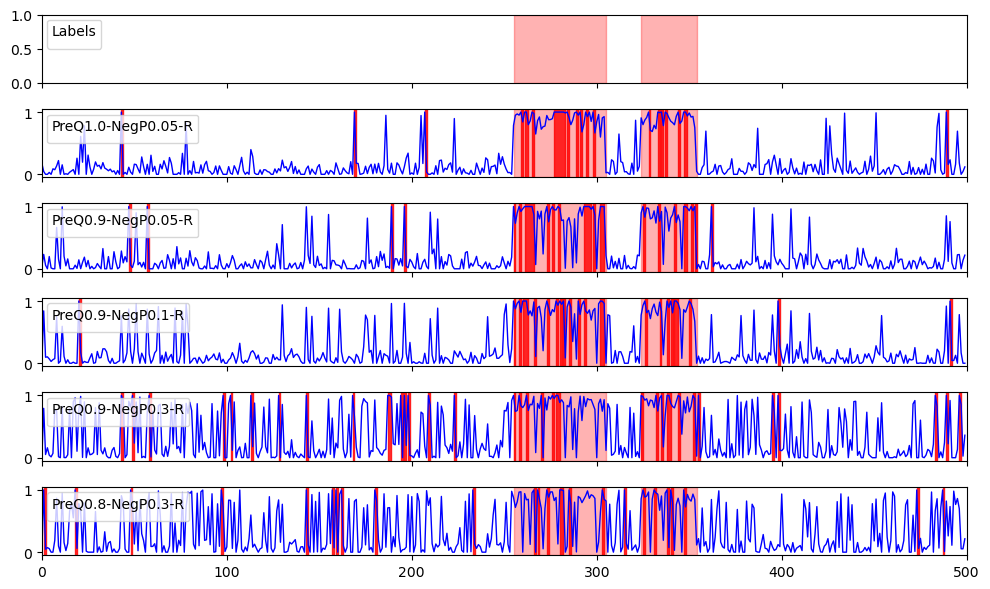

In [40]:
# model_list = ['LOF','IForest','LSTMAD', 'USAD', 'AnomalyTransformer','Random']
import sys
pth = r'/home/zzj/projects/CCE/logs/RealWorldAD'
import numpy as np
import pandas as pd

sys.path.append('/home/zzj/projects/CCE/')
from src.metrics.basic_metrics import basic_metricor
from src.evaluation.eval_metrics.eval_utils import generate_continuous_segments, ModelConfigUtils, create_model_scores
metric_list_ = ['CCE', 'Reduced-F1', 'eTaPR', 'Aff-F1', 'VUS-ROC']#,'PATE']

np.random.seed(43)
test_y = generate_continuous_segments(500,2, 50,30)
models_config_list = [
    {
        'name': 'PreQ-NegP',
        'q': 0.9,
        'p': 0.05,
    },
    {
        'name': 'PreQ-NegP',
        'q': 0.9,
        'p': 0.1,
    },
    {
        'name': 'PreQ-NegP',
        'q': 0.9,
        'p': 0.0,
    },
    {
        'name': 'PreQ-NegP',
        'q': 0.6,
        'p': 0.1,
    },
]

noise_std=0.1
models_config_list = [
    {
        'name': 'PreQ-NegP-R',
        'q': 1.0,
        'p': 0.05,
        'noise_std': noise_std,
    },
    {
        'name': 'PreQ-NegP-R',
        'q': 0.9,
        'p': 0.05,
        'noise_std': noise_std,
    },
    {
        'name': 'PreQ-NegP-R',
        'q': 0.9,
        'p': 0.1,
        'noise_std': noise_std,
    },
    {
        'name': 'PreQ-NegP-R',
        'q': 0.9,
        'p': 0.3,
        'noise_std': noise_std,
    },
    {
        'name': 'PreQ-NegP-R',
        'q': 0.8,
        'p': 0.3,
        'noise_std': noise_std,
    },
]

def trans2name(dic):
    nm = dic['name']
    
    nm = nm.replace('PreQ', f'PreQ{dic["q"]}')
    nm = nm.replace('NegP', f'NegP{dic["p"]}')
    return nm
        

def plot_syn(test_y, models_config_list,cal_metric=True,plot_labels=False):
    import matplotlib.pyplot as plt
    fz = 8
    quantile = 0.95
    linewidth=1
    show_range = [0, len(test_y)]
    bm = basic_metricor()
    if plot_labels:
        N_plot = len(models_config_list)+1
    else:
        N_plot = len(models_config_list)
    anom_ranges = bm.range_convers_new(test_y)
    plt.subplots(N_plot, 1, figsize=(10, 1*N_plot), sharex=True)
    if plot_labels:
        plt.subplot(N_plot, 1, 1)
        for i, anom_range in enumerate(anom_ranges):
            plt.axvspan(anom_range[0]-show_range[0], anom_range[1]-show_range[0], color='red', alpha=0.3)#, label='Anomaly Range' if i==0 else None)
        plt.legend(title='Labels', loc='upper left', fontsize=fz)
    # 加一个文字框
    results = {}
    
    for i, model in enumerate(models_config_list):
        config = create_model_scores(model)
        score = config['func'](test_y)
        model = trans2name(model)
        thresh = np.percentile(score, quantile*100)
        if plot_labels:
            plt.subplot(N_plot, 1, i+2)
        else:
            plt.subplot(N_plot, 1, i+1)
        # minmax
        min_, max_ = np.min(score), np.max(score)
        score = (score - np.min(score)) / (np.max(score) - np.min(score))
        thresh = (thresh - min_) / (max_ - min_)
        plt.plot(score[show_range[0]:show_range[1]+1], color='blue', linewidth=linewidth)
        pred = (score >= thresh).astype(int)
        pred_ranges = bm.range_convers_new(pred)
        for pred_range in pred_ranges:
            plt.axvspan(pred_range[0]-show_range[0], pred_range[1]-show_range[0], color='red', alpha=0.8)#, label='Prediction' if i==0 else None)
        for i, anom_range in enumerate(anom_ranges):
            plt.axvspan(anom_range[0]-show_range[0], anom_range[1]-show_range[0], color='red', alpha=0.3)

        plt.legend(title=model, loc='upper left', fontsize=fz)
        plt.xticks(np.arange(0,show_range[1]-show_range[0]+1,100),np.arange(show_range[0], show_range[1]+1, 100), rotation=0)
        plt.xlim(0, show_range[1] - show_range[0])

        if cal_metric:
            tmp_y = test_y.copy()[show_range[0]:show_range[1]+1]
            tmp_score = score.copy()[show_range[0]:show_range[1]+1]
            tmp_pred = pred.copy()[show_range[0]:show_range[1]+1]
            res = {}
            for mt in metric_list_:
                val = bm.metric_by_name(mt, tmp_y, tmp_score, tmp_pred)
                res[mt] = val
            results[model] = res
    out_pth = r'/home/zzj/projects/CCE/logs/RealWorldAD/SYN'
    import os
    if not os.path.exists(out_pth):
        os.makedirs(out_pth)
    # 打印结果
    if cal_metric:
        results = pd.DataFrame(results).T
        print(results)
        results.to_latex(f'{out_pth}/syn_results.txt', float_format='%.3f')

    
    plt.tight_layout()
    plt.savefig(f'{out_pth}/syn_plot.jpg', dpi=400)
    plt.show()

plot_syn(test_y, models_config_list)
    
